<a href="https://colab.research.google.com/github/eyalgur1/Machine_Learning_Techniques/blob/main/RegressionComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Packages and Data Generation**🚫

In [9]:
#@title #####**Import Packages**🚫
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from IPython.display import Latex
import sklearn
import sklearn.ensemble
import sklearn.tree
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import xgboost as xgb
import importlib

In [ ]:
#@title #####**Mount Drive and Install Latex**🚫

from google.colab import drive
drive.mount("/content/drive/")

# Install LaTeX and related packages
!sudo apt-get update -qq
!sudo apt-get install -y texlive texlive-latex-extra dvipng texlive-fonts-recommended cm-super

plt.rcParams.update({
    "text.usetex": True,             # Use LaTeX for all text
    "font.family": "serif",          # Use serif fonts
    "font.serif": ["Computer Modern Roman"],  # Use Computer Modern Roman font
    "text.latex.preamble": r"\usepackage{amsmath}",  # Load additional packages
    "font.size": 16,                 # Default font size
    "axes.titlesize": 14,            # Title font size
    "axes.labelsize": 14,            # Axis labels font size
    "xtick.labelsize": 14,           # X-tick labels font size
    "ytick.labelsize": 14,           # Y-tick labels font size
    "legend.fontsize": 14
})

In [11]:
#@title #####**Functions for Generation of Tabular Data**🚫

def createTabularData(features, target, scaler, val_per, test_per):
    # Input:
    # features: a numerical array of column features
    # target: a numerical array of target labels
    # scaler: a string with 'minmax' or 'standard' data scaler
    # Output:
    # dataset: dictionary with 6 items: feature_train/val/test and target_train/val/test


    # Split to train/validation/test sets (before preprocessing)
    X_train_pre, X_remain, y_train_pre, y_remain = train_test_split(features, target.reshape(-1,1), test_size=val_per+test_per, random_state=1)  # split and fix the seed
    X_val_pre, X_test_pre, y_val_pre, y_test_pre = train_test_split(X_remain, y_remain, test_size=test_per/(val_per+test_per), random_state=1)


    # Initialize scalers to normalize the data to have the same scale
    if scaler.lower() in ['minmax']:
        scaler_X = sklearn.preprocessing.MinMaxScaler()  # initializes a scaler that scales any column to [0,1] (column-wise)
        scaler_y = sklearn.preprocessing.MinMaxScaler()  # scaler for y
    elif scaler.lower() in ['standard']:
        scaler_X = sklearn.preprocessing.StandardScaler()  # initializes a scaler by removing the mean and scaling to unit variance (column-wise)
        scaler_y = sklearn.preprocessing.StandardScaler()  # scaler for y
    else:
        raise ValueError("No scaler named '"+scaler.lower()+"'. Set scaler='minmax' or scaler='standard'.")


    # Scale the data according to the training set
    # Tranforms that data according to the limits already set by the training set
    X_train = scaler_X.fit_transform(X_train_pre)
    X_val, X_test = (scaler_X.transform(X_val_pre), scaler_X.transform(X_test_pre))
    y_train = scaler_y.fit_transform(y_train_pre)
    y_val, y_test = (scaler_y.transform(y_val_pre), scaler_y.transform(y_test_pre))


    tabular_dataset = dict(feature_train = X_train, target_train = y_train,
                           feature_val = X_val, target_val = y_val,
                           feature_test = X_test, target_test = y_test,
                           inv_feature_scale = scaler_X.inverse_transform,
                           inv_target_scale = scaler_y.inverse_transform)
    return tabular_dataset


# Auxiliary function for dynamic data import by the user
def dynamic_import(module_name: str, object_name: str):
    # Import the module dynamically
    module = importlib.import_module(module_name)

    # Import the specific object from the module
    imported_object = getattr(module, object_name)

    return imported_object

## **Implementation of Regressors**🚫

In [4]:
#@title #####**Functions for Instantiation of Regressors (to be deleted)**🚫
#@markdown For the regression task, we use the following six regressors: Decision Tree, Bagged Trees, Random Forest, Gradient Boosting, Linear Regression, and Neural Network.
"Decision Tree"
# Decision tree regressor: predicts the value of a target variable by learning simple (if-then-else) decision rules.
# A tree can be seen as a piecewise constant approximation.
#def decisionTreeReg(max_depth):
 #   return sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)


"Bagged Trees"
# Bagging regressor: fits base regressors each on random subsets of the original dataset,
# and then aggregates their individual predictions (by averaging) to form a final prediction.
# Reduces the variance of an estimator by introducing randomization.
# This implementaion considers all dataset (hence, just shuffles the data for each tree).
# def baggedTreesReg(n_estimators, max_depth):
#     return sklearn.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(max_depth=max_depth),
#                                          n_estimators=n_estimators, verbose = 1,
#                                          warm_start = True)


"Random Forest"
# Random forest regressor: fits a number of decision tree regressors on (possibly various random sub-samples of) the dataset,
# by randomly selecting a sub-set of the features at each split,
# and averages to improve the predictive accuracy and control over-fitting.
# Equivalent to Bagged Trees if selecting all features at each split.
# This implementaion considers all dataset (hence, just shuffles the data for each tree).
#def randomForestReg(n_estimators, max_depth):
#    return sklearn.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features = "sqrt")


"Gradient Boosting"
# Gradient boosting regressor: a functional gradient descent on fitted trees,
# where at iteration we fit a tree using the previous fits as a "descent direction".
# Here we use XGBoost as an API for sklearn.
#def gradBoostReg(n_estimators, max_depth, lr):
 #   return xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators,
  #                               learning_rate=lr, max_depth=max_depth, eval_metric=['rmse'])


"Linear Regression"
# Linear regressor: a simple l2-regression with exact solution.
# Using a polynomial linear regression for multi-feature setting is expensive,
# as the Vandermonde matrix is too large for accurate inversion even when the poly degree is small.
# For a polynomial linear regression, one can use gradient descent.
def linearReg(intercept=False):
    def leastSqaures(A, b):
        if ~intercept:  # if intercept is not required
            A = np.append(np.ones((A.shape[0], 1)), A, 1)  # append column of ones for free coefficient (Vendermonde)
        AT = np.transpose(A)
        return 0.5*np.linalg.inv(AT@A)@AT@b  # return least squares solution
    return leastSqaures


"Neuarl Network"
# Neural network regressor: a simple regression PyTorch net with one hidden layer.
# The activation function is ReLU, optimizer is Adam, loss is MSELoss, and lr is given by the user.
# This function returns the model, criterion (loss), and the optimizer.
def neuralNetReg(input_dim, hidden_dim, output_dim, lr):

    class SimpleRegressionModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(SimpleRegressionModel, self).__init__()
            self.hidden = nn.Linear(input_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.output = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            x = self.hidden(x)
            x = self.relu(x)
            x = self.output(x)

    model = SimpleRegressionModel(input_dim, hidden_dim, output_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return model, criterion, optimizer

In [12]:
#@title #####*Gradient Boosting Trainer*
def gradBoostRegTrain(dataset, num_epochs, n_estimators, lr, max_depth):

    gradBoost = xgb.XGBRegressor(objective='reg:squarederror', n_estimators = n_estimators,
                                 learning_rate = lr, max_depth = max_depth, eval_metric = ['rmse'])

    X_train = dataset['feature_train'];  y_train = dataset['target_train']
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    eval_set = [(X_train, y_train), (dataset['feature_val'], dataset['target_val'])]
    inv_y_scale = dataset['inv_target_scale']
    verbosity = gradBoost.n_estimators
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':0, 'num_epochs':num_epochs}

    print("\033[4mGradient Boosting Regressor Training\033[0m", '\n')
    print("Notice: validation_0=Training Set, validation_1=Validation Set", '\n')


    # Training loop
    for epoch in range(num_epochs):
        print('Epoch ', str(epoch+1), '/', str(num_epochs))
        if epoch == 0:  # first epoch
            gradBoost.fit(X_train, y_train, eval_set=eval_set, verbose=verbosity)
            # eval_set: the data on which to track metric evaluation; can also be set as eval_set=[(X_train, y_train)]; eval_set is not used for training
            # verbose: integer specifying the intervals of trees to specify metrics for (out of n_estimators in total)
        else:
            gradBoost.fit(X_train, y_train, eval_set=eval_set, verbose=verbosity, xgb_model=gradBoost.get_booster())
            # after the first epoch, we use the previous fitted model as starting point with the command xgb_model=xgb_model.get_booster()


        # Save MSE for later plotting
        results_epoch = gradBoost.evals_result()
        results['mse_train'] = np.append(results['mse_train'], np.array(results_epoch['validation_0']['rmse'])**2)
        results['mse_val'] = np.append(results['mse_val'], np.array(results_epoch['validation_1']['rmse'])**2)

    y_pred = gradBoost.predict(X_test).reshape(-1,1)
    results['mse_test'] = mean_squared_error(y_test, y_pred)

    # Evaluate the model's performance (transform back to terms of original prices)
    mse_test_price = mean_squared_error(inv_y_scale(y_test), inv_y_scale(y_pred))
    print('\n', 'Test MSE: ', results['mse_test'])
    print('Test MSE in terms of original prices: ', mse_test_price, '\n')

    return gradBoost, results


def gradBoostPlot(gradBoost, results):
    # Training and validation sets
    plt.figure(figsize=(5, 3))
    plt.semilogy(results['mse_train'])  # the training set
    plt.semilogy(results['mse_val'])  # the validation set
    plt.title('Gradient Boosting: MSE')
    plt.xlabel(r'Iterations (\#trees $\times$ \#epochs)')
    xlim = gradBoost.n_estimators*results['num_epochs']
    plt.xlim([0, xlim])

    # Test set prediction
    plt.semilogy(np.ones((xlim, 1))*results['mse_test'])
    plt.legend(['Training set', 'Validation set', 'Test set output'])
    plt.show()
    print('\n\n\n')

In [40]:
#@title #####*Bagged Trees Trainer*

def baggedTreesRegTrain(dataset, max_depth, n_estimators):

    X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    X_val = dataset['feature_val']; y_val = dataset['target_val']
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    inv_y_scale = dataset['inv_target_scale']
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':np.array([]), 'max_depth':max_depth, 'n_estimators':n_estimators}

    print("\033[4mBagged Trees Regressor Training\033[0m", '\n')


    # Training loop
    for depth in range(max_depth):
        print('Depth', str(depth+1), '/', str(max_depth))
        baggedTrees = sklearn.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(max_depth=depth+1), verbose = 1)
        baggedTrees.fit(X_train, y_train)

        y_depth_train = baggedTrees.predict(X_train).reshape(-1,1); mse_train = mean_squared_error(y_train, y_depth_train)
        y_depth_val = baggedTrees.predict(X_val).reshape(-1,1); mse_val = mean_squared_error(y_val, y_depth_val)
        y_depth_test = baggedTrees.predict(X_test).reshape(-1,1); mse_test = mean_squared_error(y_test, y_depth_test)
        print('Training MSE: ', mse_train, '| Validation MSE: ', mse_val, '| Test MSE: ', mse_test, '\n')

        # Save MSE for later plotting
        results['mse_train'] = np.append(results['mse_train'], mse_train)
        results['mse_val'] = np.append(results['mse_val'], mse_val)
        results['mse_test'] = np.append(results['mse_test'], mse_test)


    # Evaluate the model's performance (transform back to terms of original prices)
    mse_test_price = mean_squared_error(inv_y_scale(y_test).reshape(-1,1), inv_y_scale(y_depth_test).reshape(-1,1))  # convert to previous prices for the maximal depth
    print('\n', 'Test MSE for maximal depth: ', results['mse_test'][-1])
    print('Test MSE in terms of original prices for maximal depth: ', mse_test_price, '\n')


    "This code below updates the Bagged Trees with an epoch loop (instead of a depth loop), and increases the number of estimators at each epoch with awarm start of the prvious fit model"
    "The corresponding plotting function is not updated according to this variant"
    # X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    # X_val = dataset['feature_val']; y_val = dataset['target_val']
    # X_test = dataset['feature_test'];  y_test = dataset['target_test']
    # inv_y_scale = dataset['inv_target_scale']
    # trees_per_epoch = n_estimators // num_epochs
    # results = {'mse_train':np.array([]), 'mse_val':np.array([])}

    # baggedTrees = sklearn.ensemble.BaggingRegressor(estimator=sklearn.tree.DecisionTreeRegressor(max_depth=max_depth),
    #                                      n_estimators = trees_per_epoch, verbose = 1,
    #                                      warm_start = True)

    # print("\033[4mBagged Trees Regressor Training\033[0m", '\n')


    # # Training loop
    # for epoch in range(num_epochs):
    #     print('Epoch', str(epoch+1), '/', str(num_epochs), '|| #estimators:', baggedTrees.n_estimators)
    #     baggedTrees.fit(X_train, y_train)

    #     y_epoch_train = baggedTrees.predict(X_train).reshape(-1,1); mse_train = mean_squared_error(y_train, y_epoch_train)
    #     y_epoch_val = baggedTrees.predict(X_val).reshape(-1,1); mse_val = mean_squared_error(y_val, y_epoch_val)
    #     print('Training MSE: ', mse_train, '| Validation MSE: ', mse_val, '\n')

    #     # Save MSE for later plotting
    #     results['mse_train'] = np.append(results['mse_train'], mse_train)
    #     results['mse_val'] = np.append(results['mse_val'], mse_val)

    #     baggedTrees.n_estimators += trees_per_epoch


    # y_pred = baggedTrees.predict(X_test).reshape(-1,1)
    # results['mse_test'] = mean_squared_error(y_test, y_pred)

    # # Evaluate the model's performance (transform back to terms of original prices)
    # mse_test_price = mean_squared_error(inv_y_scale(y_test), inv_y_scale(y_pred))
    # print('\n', 'Test MSE: ', results['mse_test'])
    # print('Test MSE in terms of original prices: ', mse_test_price, '\n')

    return baggedTrees, results


def baggedTreesPlot(baggedTrees, results):
    # Training and validation sets
    plt.figure(figsize=(5, 3))
    plt.plot(results['mse_train'])  # the training set
    plt.plot(results['mse_val'])  # the validation set
    plt.plot(results['mse_test'])  # the test set
    plt.title("Bagged Trees (with "+str(results['n_estimators'])+" estimators): MSE")
    plt.xlabel(r'Depth')
    xlim = results['max_depth']
    plt.xlim([0, xlim-1])
    xticks = [tick for tick in range(0,xlim)]
    xtick_labels = [f'{tick+1}' for tick in range(0,xlim)]
    plt.xticks(xticks, xtick_labels)


    plt.legend(['Training set', 'Validation set', 'Test set'])
    plt.show()
    print('\n\n\n')

In [14]:
#@title #####*Random Forest Trainer*

def randomForestRegTrain(dataset, max_depth, n_estimators):

    X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    X_val = dataset['feature_val']; y_val = dataset['target_val']
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    inv_y_scale = dataset['inv_target_scale']
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':np.array([]), 'max_depth':max_depth, 'n_estimators':n_estimators}

    print("\033[4mRandom Forest Regressor Training\033[0m", '\n')


    # Training loop
    for depth in range(max_depth):
        print('Depth', str(depth+1), '/', str(max_depth))
        randomForest = sklearn.ensemble.RandomForestRegressor(max_features='sqrt', n_estimators=n_estimators, max_depth=depth+1, verbose = 1)
        randomForest.fit(X_train, y_train)

        y_depth_train = randomForest.predict(X_train).reshape(-1,1); mse_train = mean_squared_error(y_train, y_depth_train)
        y_depth_val = randomForest.predict(X_val).reshape(-1,1); mse_val = mean_squared_error(y_val, y_depth_val)
        y_depth_test = randomForest.predict(X_test).reshape(-1,1); mse_test = mean_squared_error(y_test, y_depth_test)
        print('Training MSE: ', mse_train, '| Validation MSE: ', mse_val, '| Test MSE: ', mse_test, '\n')

        # Save MSE for later plotting
        results['mse_train'] = np.append(results['mse_train'], mse_train)
        results['mse_val'] = np.append(results['mse_val'], mse_val)
        results['mse_test'] = np.append(results['mse_test'], mse_test)


    # Evaluate the model's performance (transform back to terms of original prices)
    mse_test_price = mean_squared_error(inv_y_scale(y_test).reshape(-1,1), inv_y_scale(y_depth_test).reshape(-1,1))  # convert to previous prices for the maximal depth
    print('\n', 'Test MSE for maximal depth: ', results['mse_test'][-1])
    print('Test MSE in terms of original prices for maximal depth: ', mse_test_price, '\n')


    "Random Forest can be trained with an epoch loop (instead of a depth loop -- see note at the bottom of the Bagged Tree Regressor function), and increases the number of estimators at each epoch with a warm start of the prvious fit model"
    "The corresponding plotting function is not updated according to this variant"

    return baggedTrees, results


def randomForestPlot(baggedTrees, results):
    # Training and validation sets
    plt.figure(figsize=(5, 3))
    plt.plot(results['mse_train'])  # the training set
    plt.plot(results['mse_val'])  # the validation set
    plt.plot(results['mse_test'])  # the test set
    plt.title("Random Forest (with "+str(results['n_estimators'])+" estimators): MSE")
    plt.xlabel(r'Depth')
    xlim = results['max_depth']
    plt.xlim([0, xlim-1])
    xticks = [tick for tick in range(0,xlim)]
    xtick_labels = [f'{tick+1}' for tick in range(0,xlim)]
    plt.xticks(xticks, xtick_labels)


    plt.legend(['Training set', 'Validation set', 'Test set'])
    plt.show()
    print('\n\n\n')

In [15]:
#@title #####*Decision Tree Trainer*

def decisionTreeRegTrain(dataset, max_depth):

    X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    X_val = dataset['feature_val']; y_val = dataset['target_val']
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    inv_y_scale = dataset['inv_target_scale']
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':np.array([]), 'max_depth':max_depth}

    print("\033[4mDecision Tree Regressor Training\033[0m", '\n')


    # Training loop
    for depth in range(max_depth):
        print('Depth', str(depth+1), '/', str(max_depth))
        decisionTree = sklearn.tree.DecisionTreeRegressor(max_depth = depth+1)
        decisionTree.fit(X_train, y_train)

        y_depth_train = decisionTree.predict(X_train).reshape(-1,1); mse_train = mean_squared_error(y_train, y_depth_train)
        y_depth_val = decisionTree.predict(X_val).reshape(-1,1); mse_val = mean_squared_error(y_val, y_depth_val)
        y_depth_test = decisionTree.predict(X_test).reshape(-1,1); mse_test = mean_squared_error(y_test, y_depth_test)
        print('Training MSE: ', mse_train, '| Validation MSE: ', mse_val, '| Test MSE: ', mse_test, '\n')

        # Save MSE for later plotting
        results['mse_train'] = np.append(results['mse_train'], mse_train)
        results['mse_val'] = np.append(results['mse_val'], mse_val)
        results['mse_test'] = np.append(results['mse_test'], mse_test)


    # Evaluate the model's performance (transform back to terms of original prices)
    mse_test_price = mean_squared_error(inv_y_scale(y_test).reshape(-1,1), inv_y_scale(y_depth_test).reshape(-1,1))  # convert to previous prices for the maximal depth
    print('\n', 'Test MSE for maximal depth: ', results['mse_test'][-1])
    print('Test MSE in terms of original prices for maximal depth: ', mse_test_price, '\n')

    return decisionTree, results


def decisionTreePlot(decisionTree, results):
    # Training and validation sets
    plt.figure(figsize=(5, 3))
    plt.plot(results['mse_train'])  # the training set
    plt.plot(results['mse_val'])  # the validation set
    plt.plot(results['mse_test'])  # the test set
    plt.title('Decision Tree: MSE')
    plt.xlabel(r'Depth')
    xlim = results['max_depth']
    plt.xlim([0, xlim-1])
    xticks = [tick for tick in range(0,xlim)]
    xtick_labels = [f'{tick+1}' for tick in range(0,xlim)]
    plt.xticks(xticks, xtick_labels)


    plt.legend(['Training set', 'Validation set', 'Test set'])
    plt.show()
    print('\n\n\n')

In [36]:
#@title #####*$\ell_2$ Linear Regression*

def linearRegTrain(dataset, intercept=False):

    X_train = dataset['feature_train'];  y_train = dataset['target_train'].ravel()
    # notice that there is no need here for the validation set, as there is no loop here (so there is no need to deduce from a validation set regarding hyperparameters)
    X_test = dataset['feature_test'];  y_test = dataset['target_test']
    inv_y_scale = dataset['inv_target_scale']
    results = {'mse_train':np.array([]), 'mse_val':np.array([]), 'mse_test':np.array([])}

    def leastSqaures(A_train, b, intercept, A_test):
        if ~intercept:  # if intercept is not required
            A_train = np.append(np.ones((A_train.shape[0], 1)), A_train, 1)  # append column of ones for free coefficient (Vendermonde)
            A_test = np.append(np.ones((A_test.shape[0], 1)), A_test, 1)
        AT_train = np.transpose(A_train)
        return 0.5*np.linalg.inv(AT_train@A_train)@AT_train@b, A_train, A_test  # return least squares solution

    print("\033[4m$\ell_2$ Linear Regression Training\033[0m", '\n')

    linearReg, A_train, A_test = leastSqaures(X_train, y_train, intercept, X_test)

    y_pred_train = A_train@linearReg; y_pred_train = y_pred_train.reshape(-1,1)
    mse_train = mean_squared_error(y_pred_train, y_train); results['mse_train'] = mse_train

    y_pred = A_test@linearReg; y_pred = y_pred.reshape(-1,1)
    mse_test = mean_squared_error(y_pred, y_test); results['mse_test'] = mse_test
    mse_test_price = mean_squared_error(inv_y_scale(y_test), inv_y_scale(y_pred))
    print('Training MSE: ', mse_train, '| Test MSE: ', mse_test, '\n', 'Test MSE in terms of original prices: ', mse_test_price, '\n\n')

    return linearReg, results

In [17]:
# @title **Generate Tabular Dataset**👇

# @markdown ## **Define a Tabular Dataset**
# @markdown Tick for choosing a dataset from `sklearn.datasets` and enter its name. Else, the local `kaggle` dataset `weatherww2` is loaded.
sklearn_dataset = False # @param {type:"boolean"}
if sklearn_dataset:
    module_name = "sklearn.datasets"
    object_name = "fetch_california_housing" # @param {type:"string"}
    dataset_object = dynamic_import(module_name, object_name)  # each row in this dataset is the average of several houses in one block
    raw_dataset = pd.DataFrame(data = dataset_object())  # convert to a pandas DataFrame (for better treating of missing values)
else:
    path = '/content/drive/MyDrive/Colab_Notebooks/Machine_and_Deep_Learning/ML/melbourne_housing.csv'
    dataset_object = pd.read_csv(path)
    raw_dataset = dataset_object.drop(['Suburb', 'Address', 'Type','Method','SellerG','Date','CouncilArea','Regionname'], axis=1)  # delete these columns


# Remove all rows with missing values (hence, it assumes that the data is highly non-sparse)
# Removing missing values using `pandas` (treats all types of mssing values at once, unlike numpy)
raw_dataset = raw_dataset.dropna(how='any')  # drop any row that has at least one NaN, either in the features


# @markdown Set percentage of the validation and test sets out of the complete data (the remainder is the training set).
val_per = 0.1 # @param {type:"number"}
test_per = 0.2 # @param {type:"number"}


# @markdown Set data scaler type (`minmax` or `standard`)
scaler = 'minmax' # @param {type:"string"}


# Create a tabular numeric dataset (clean and scale)
if sklearn_dataset:
    dataset = createTabularData(features=np.array(raw_dataset['data']), target=np.array(raw_dataset['target']),
                      scaler=scaler, val_per=val_per, test_per=test_per)
else: dataset = createTabularData(features=np.array(raw_dataset.drop('Price', axis=1)), target=np.array(raw_dataset['Price']).reshape(-1,1),
                      scaler=scaler, val_per=val_per, test_per=test_per)

# Training the Models

In [38]:
#@title **Set Hyperparameters**👇

kNN = True
decision_tree = True; max_depth_DT = 10
bagged_trees = True ; n_estimators_BT = 100 ; max_depth_BT = 10;
random_forest = True ; n_estimators_RF = 100 ; max_depth_RF = 10
gradient_boosting = True ; n_estimators_GB = 100 ; max_depth_GB = 5 ; lr_GB = 0.1; num_epochs_GB = 5
linear_regression = True ; intercept = False
neural_network = True; hidden_dim_NN = 10 ; lr_NN = 0.01

Decision Tree Regressor Training 

Depth 1 / 10
Training MSE:  0.004571526055145694 | Validation MSE:  0.004217304411395307 | Test MSE:  0.004611761057289384 

Depth 2 / 10
Training MSE:  0.003526034539433057 | Validation MSE:  0.003096615007587845 | Test MSE:  0.0034851438708104064 

Depth 3 / 10
Training MSE:  0.002744061023959551 | Validation MSE:  0.0025177646380188834 | Test MSE:  0.0027532047975811352 

Depth 4 / 10
Training MSE:  0.002240820098152539 | Validation MSE:  0.002164934804800351 | Test MSE:  0.0025484968756593904 

Depth 5 / 10
Training MSE:  0.0018656597942343237 | Validation MSE:  0.0020970473967792057 | Test MSE:  0.002340158048680599 

Depth 6 / 10
Training MSE:  0.0015137031400493668 | Validation MSE:  0.0017524022345051262 | Test MSE:  0.00206884701344196 

Depth 7 / 10
Training MSE:  0.00125214892403073 | Validation MSE:  0.0016628591498841164 | Test MSE:  0.0018495243792600526 

Depth 8 / 10
Training MSE:  0.0010258009869467248 | Validation MSE:  0.00188147818

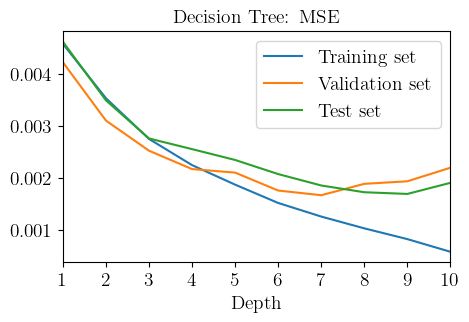





Bagged Trees Regressor Training 

Depth 1 / 10
Training MSE:  0.004446344343126241 | Validation MSE:  0.004038043693429002 | Test MSE:  0.00456736677363582 

Depth 2 / 10
Training MSE:  0.0033241145183868083 | Validation MSE:  0.0029073012397677167 | Test MSE:  0.003327984888036816 

Depth 3 / 10
Training MSE:  0.002546806777886126 | Validation MSE:  0.0023005343977564145 | Test MSE:  0.0025443376382329372 

Depth 4 / 10
Training MSE:  0.002019275604962507 | Validation MSE:  0.0018919333366294645 | Test MSE:  0.002173362075738029 

Depth 5 / 10
Training MSE:  0.0016057413460211847 | Validation MSE:  0.0016265495822714545 | Test MSE:  0.0018919647305494544 

Depth 6 / 10
Training MSE:  0.0012938989146656032 | Validation MSE:  0.0013397022905109503 | Test MSE:  0.0016209885710002923 

Depth 7 / 10
Training MSE:  0.0010763862261792354 | Validation MSE:  0.0012816847788805997 | Test MSE:  0.0014413154819070465 

Depth 8 / 10
Training MSE:  0.0008605522878372529 | Validation MSE:  0.001

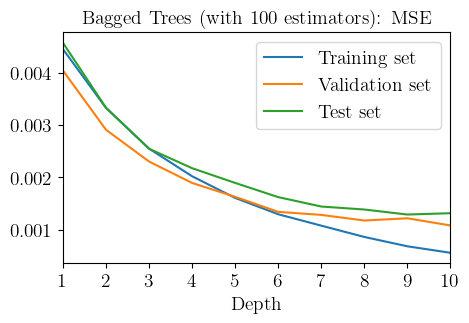





Random Forest Regressor Training 

Depth 1 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.004434460518619743 | Validation MSE:  0.00362319974019896 | Test MSE:  0.004471407165026892 

Depth 2 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.003433213048972702 | Validation MSE:  0.0027569751584491054 | Test MSE:  0.003491731217494017 

Depth 3 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0025573874520324223 | Validation MSE:  0.0020746027005581072 | Test MSE:  0.0026110110865301237 

Depth 4 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0019958775085729273 | Validation MSE:  0.001617943031356154 | Test MSE:  0.0021142542512949934 

Depth 5 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0016233207434391307 | Validation MSE:  0.0013412744091437694 | Test MSE:  0.0017542619207672186 

Depth 6 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0013397416532434532 | Validation MSE:  0.001177553244337658 | Test MSE:  0.001542516311285785 

Depth 7 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0011249734150813675 | Validation MSE:  0.001058646459897008 | Test MSE:  0.0013939729571024195 

Depth 8 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0008939434919089121 | Validation MSE:  0.0009559068017978642 | Test MSE:  0.001234734768075051 

Depth 9 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0007189581690567604 | Validation MSE:  0.0009072816950658961 | Test MSE:  0.0012100745974238682 

Depth 10 / 10


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Training MSE:  0.0005585315961748364 | Validation MSE:  0.0008762893206990367 | Test MSE:  0.0011391991195674337 


 Test MSE for maximal depth:  0.0011391991195674337
Test MSE in terms of original prices for maximal depth:  89608446957.113 



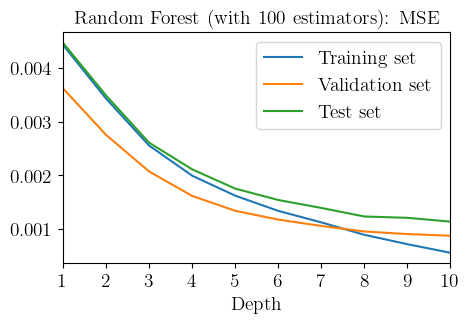





Gradient Boosting Regressor Training 

Notice: validation_0=Training Set, validation_1=Validation Set 

Epoch  1 / 5
[0]	validation_0-rmse:0.07213	validation_1-rmse:0.06531
[99]	validation_0-rmse:0.02255	validation_1-rmse:0.02969
Epoch  2 / 5
[0]	validation_0-rmse:0.02253	validation_1-rmse:0.02970
[99]	validation_0-rmse:0.01819	validation_1-rmse:0.02906
Epoch  3 / 5
[0]	validation_0-rmse:0.01815	validation_1-rmse:0.02905
[99]	validation_0-rmse:0.01568	validation_1-rmse:0.02887
Epoch  4 / 5
[0]	validation_0-rmse:0.01564	validation_1-rmse:0.02886
[99]	validation_0-rmse:0.01348	validation_1-rmse:0.02895
Epoch  5 / 5
[0]	validation_0-rmse:0.01345	validation_1-rmse:0.02897
[99]	validation_0-rmse:0.01188	validation_1-rmse:0.02890

 Test MSE:  0.0010191501735166292
Test MSE in terms of original prices:  80165497939.35774 



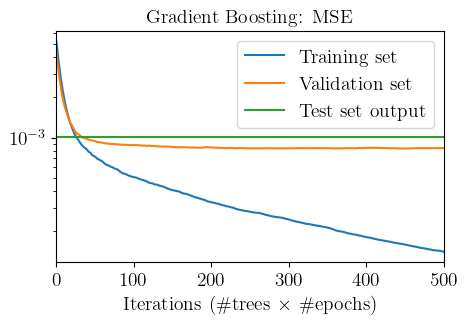





$\ell_2$ Linear Regression Training 

Training MSE:  0.006273091767099563 | Test MSE:  0.006404290446434934 
 Test MSE in terms of original prices:  503756113316.8874 




In [41]:
# Technically, for Decision Tree, Bagged Trees, Random Forest the process sould be as follows:
# we train over the training set and validate over the validation set each time in the loop
# (these loops fit a different model every time -- so it is just for visulization as there is no continuation between consecuitive models in the training loop).
# then, we evaluate the best model over the validation sets only once over the test set -- and this is the final outcome.

if decision_tree:
    decisionTree, results_DT = decisionTreeRegTrain(dataset=dataset, max_depth=max_depth_DT)
    decisionTreePlot(decisionTree, results_DT)

# the different depth in the loop are just fir visualization, as every time a different model is trained!!
if bagged_trees:
    baggedTrees, results_BT = baggedTreesRegTrain(dataset=dataset, max_depth=max_depth_BT, n_estimators=n_estimators_BT)
    baggedTreesPlot(baggedTrees, results_BT)

# the different depth in the loop are just fir visualization, as every time a different model is trained!!
if random_forest:
    randomForest, results_RF = randomForestRegTrain(dataset=dataset, max_depth=max_depth_RF, n_estimators=n_estimators_RF)
    randomForestPlot(randomForest, results_RF)


if gradient_boosting:
    gradBoost, results_GB = gradBoostRegTrain(dataset=dataset, num_epochs=num_epochs_GB, n_estimators=n_estimators_GB, lr=lr_GB, max_depth=max_depth_GB)
    gradBoostPlot(gradBoost, results_GB)


if linear_regression:
    linearReg, results_LR = linearRegTrain(dataset=dataset)

In [ ]:
# #@title **Set Hyperparameters**👇
# #@markdown Number of epochs (for all methods):
# #@markdown ---


# num_epochs = 2 # @param {type:"integer"}
# #@markdown ---
# #@markdown Choose regressors and set their hyperparameters:
# #@markdown ---
# decision_tree = True # @param {type:"boolean"}
# max_depth_DT = 5 # @param {type:"integer"}
# #@markdown ---
# bagged_trees = True # @param {type:"boolean"}
# n_estimators_BT = 100 # @param {type:"integer"}
# max_depth_BT = 5 # @param {type:"integer"}
# #@markdown ---
# random_forest = True # @param {type:"boolean"}
# n_estimators_RF = 100 # @param {type:"integer"}
# max_depth_RF = 5 # @param {type:"integer"}
# #@markdown ---
# gradient_boosting = True # @param {type:"boolean"}
# n_estimators_GB = 100 # @param {type:"integer"}
# max_depth_GB = 5 # @param {type:"integer"}
# lr_GB = 0.1 # @param {type:"number"}
# #@markdown ---
# linear_regression = True # @param {type:"boolean"}
# #@markdown ---
# neural_network = True # @param {type:"boolean"}
# hidden_dim_NN = 10 # @param {type:"integer"}
# lr_NN = 0.01 # @param {type:"number"}